<a href="https://colab.research.google.com/github/rahilshah10/miamilist/blob/master/Final_Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 2. Importing the Data

In [0]:
# Having all the necessary libaries for 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
from sklearn import preprocessing,metrics 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# Pandas options
# pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
# mpl.style.use('ggplot')
# sns.set(style='whitegrid')

Read the data into a pandas dataframe

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls "/content/gdrive/My Drive/Colab/loan.csv"

'/content/gdrive/My Drive/Colab/loan.csv'


In [0]:
start_df = pd.read_csv('/content/gdrive/My Drive/Colab/loan.csv', low_memory=False)

Check the basic dataframe info

In [5]:
df = start_df.copy(deep=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


There are 2.2 million rows and 145 columns. The data set is about 2.4GB.

Let's take a look at the first 5 rows to see what we are getting into.

In [6]:
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,...,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,...,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0.0,Apr-2011,0.0,NaN,NaN,8.0,0.0,4599,19.1,13.0,w,4787.21,4787.21,353.89,353.89,...,0.0,0.0,136927.0,11749.0,13800.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,MORTGAGE,92000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,985xx,WA,16.74,0.0,Feb-2006,0.0,NaN,NaN,10.0,0.0,5468,78.1,13.0,w,3831.93,3831.93,286.71,286.71,...,0.0,0.0,385183.0,36151.0,5000.0,44984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,MORTGAGE,57250.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,212xx,MD,26.35,0.0,Dec-2000,0.0,NaN,NaN,12.0,0.0,829,3.6,26.0,w,29339.02,29339.02,1423.21,1423.21,...,0.0,0.0,157548.0,29674.0,9300.0,32332.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


We also want to understand the columns we have with the data dictionary provided.

### 3. Target Variable

We are going to predict the variable loan_status. What are the value counts?

In [7]:
df['loan_status'].value_counts(dropna=False)

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

We are going to only considers the Charged Off and Fully Paid values.

In [0]:
df = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]

In [9]:
df.shape

(1303607, 145)

There are still 1303607 loans remaining. Lets recheck their status.

In [0]:
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
df= df.replace({"loan_status": di})

In [11]:
df['loan_status'].value_counts(normalize=True)

0    0.799284
1    0.200716
Name: loan_status, dtype: float64

About 80% of the loans are fully paid and the rest 20% percent are charged off, so we can see a somewhat imbalance in our target variable

### 4. Feature space limiting

The dataset consists of 145 features for each loan. We will divide our feature selection in two steps:

- Drop the features with more than 30% missing data.
-  Of the remaining features, we chose only those that would be the best ones.

### 4.1 Drop features with missing data

First calculate the percentage of missing data for each feature:

In [0]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [13]:
# Missing values statistics
miss_values = missing_values_table(df)
miss_values.head(10)

Your selected dataframe has 145 columns.
There are 105 columns that have missing values.


,Missing Values,% of Total Values
id,1303607,100.0
url,1303607,100.0
member_id,1303607,100.0
next_pymnt_d,1303607,100.0
orig_projected_additional_accrued_interest,1300174,99.7
hardship_type,1298272,99.6
hardship_reason,1298272,99.6
hardship_status,1298272,99.6
hardship_last_payment_amount,1298272,99.6
hardship_payoff_balance_amount,1298272,99.6


In [0]:
missing_fractions = df.isnull().mean().sort_values(ascending=False)

Let's visualize the distribution of missing data

Text(0, 0.5, 'Feature count')

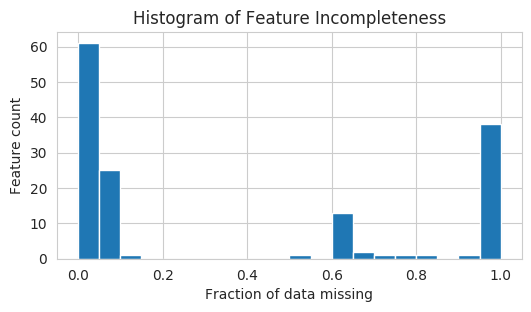

In [15]:
plt.figure(figsize=(6,3),dpi=100)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

We can see that there a huge gap between the features missing some data(<20%) and those who are missing a lot of data(>40%). Since its very difficult to impute the remaining data accurately for the columns with more than 30% missing values, we drop those columns.

First storing all columns missing more than 30% data into a list:

In [16]:
drop_list = list(missing_fractions[missing_fractions>0.3].index)
print(drop_list)

['id', 'member_id', 'url', 'next_pymnt_d', 'orig_projected_additional_accrued_interest', 'hardship_length', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_end_date', 'payment_plan_start_date', 'hardship_start_date', 'hardship_dpd', 'hardship_last_payment_amount', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'revol_bal_joint', 'sec_app_collections_12_mths_ex_med', 'sec_app_chargeoff_within_12_mths', 'sec_app_num_rev_accts', 'sec_app_open_act_il', 'sec_app_open_acc', 'sec_app_mort_acc', 'sec_app_inq_last_6mths', 'sec_app_earliest_cr_line', 'verification_status_joint', 'dti_joint', 'annual_inc_joint', 'settlement_percentage', 'settlement_term', 'settlement_status', 'settlement_amount', 'settlement_date', 'debt_settlement_flag_date', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog', 'il_util', 'mths_since_recent_revol_del

No of features being dropped

In [17]:
len(drop_list)

58

Dropping these features:

In [0]:
df.drop(labels=drop_list, axis=1, inplace=True)

In [19]:
df.shape

(1303607, 87)

### 4.2 Keeping useful features

After researching through the data dictionary we decide to keep only the use full features from all the remaining features we have.

In [20]:
features = ['annual_inc', 'grade', 'emp_length', 'funded_amnt', 
                'avg_cur_bal', 'last_pymnt_amnt', 'open_acc', 'bc_util', 'mort_acc', 'pub_rec', 
                'debt_settlement_flag', 'term', 'installment', 'int_rate', 'delinq_2yrs', 'home_ownership', 
                'acc_now_delinq', 'loan_amnt', 'total_pymnt', 'loan_status'] 
Final_data = df[features]
Final_data = Final_data.reset_index(drop=True)
Final_data.shape

(1303607, 20)

In [21]:
Final_data['emp_length'].value_counts()

10+ years    428547
2 years      117820
< 1 year     104550
3 years      104200
1 year        85677
5 years       81623
4 years       78029
6 years       60933
8 years       59125
7 years       58145
9 years       49504
Name: emp_length, dtype: int64

In [22]:
Final_data.head()

,annual_inc,grade,emp_length,funded_amnt,avg_cur_bal,last_pymnt_amnt,open_acc,bc_util,mort_acc,pub_rec,debt_settlement_flag,term,installment,int_rate,delinq_2yrs,home_ownership,acc_now_delinq,loan_amnt,total_pymnt,loan_status
0,100000.0,D,5 years,30000,42939.0,30082.32,11.0,46.9,1.0,1.0,N,36 months,1151.16,22.35,0.0,MORTGAGE,0.0,30000,30026.442500,0
1,45000.0,C,< 1 year,40000,15059.0,40910.48,18.0,67.3,1.0,0.0,N,60 months,975.71,16.14,0.0,MORTGAGE,0.0,40000,40856.678960,0
2,100000.0,A,10+ years,20000,57309.0,20228.39,9.0,29.9,5.0,0.0,N,36 months,622.68,7.56,0.0,MORTGAGE,0.0,20000,20215.792430,0
3,38500.0,B,10+ years,4500,2428.0,4553.46,12.0,28.9,0.0,0.0,N,36 months,147.99,11.31,0.0,RENT,0.0,4500,4549.217149,0
4,450000.0,E,3 years,8425,34516.0,8754.30,21.0,74.6,4.0,0.0,N,36 months,345.18,27.27,0.0,MORTGAGE,0.0,8425,8735.148975,0


### 5. Data Transformation

We need to transform some categotial values in our dataset to numerical labels so we can use it to work with some models
Grade and home_ownership should be encoded to numerical values.
Also emp_length is in a format of string i.e. "5 years","1 year" which needs to be changed to its numerical values.

In [23]:
Final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303607 entries, 0 to 1303606
Data columns (total 20 columns):
annual_inc              1303607 non-null float64
grade                   1303607 non-null object
emp_length              1228153 non-null object
funded_amnt             1303607 non-null int64
avg_cur_bal             1236059 non-null float64
last_pymnt_amnt         1303607 non-null float64
open_acc                1303607 non-null float64
bc_util                 1242221 non-null float64
mort_acc                1256326 non-null float64
pub_rec                 1303607 non-null float64
debt_settlement_flag    1303607 non-null object
term                    1303607 non-null object
installment             1303607 non-null float64
int_rate                1303607 non-null float64
delinq_2yrs             1303607 non-null float64
home_ownership          1303607 non-null object
acc_now_delinq          1303607 non-null float64
loan_amnt               1303607 non-null int64
total_pymnt   

In [24]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
Final_data["home_ownership"] = lb_make.fit_transform(Final_data["home_ownership"])
Final_data["grade"] = lb_make.fit_transform(Final_data["grade"])
Final_data["debt_settlement_flag"] = lb_make.fit_transform(Final_data["debt_settlement_flag"])
Final_data["term"] = lb_make.fit_transform(Final_data["term"])
Final_data.drop('emp_length',axis=1, inplace=True)
print("Current shape of dataset :",Final_data.shape)
Final_data.head()

Current shape of dataset : (1303607, 19)


,annual_inc,grade,funded_amnt,avg_cur_bal,last_pymnt_amnt,open_acc,bc_util,mort_acc,pub_rec,debt_settlement_flag,term,installment,int_rate,delinq_2yrs,home_ownership,acc_now_delinq,loan_amnt,total_pymnt,loan_status
0,100000.0,3,30000,42939.0,30082.32,11.0,46.9,1.0,1.0,0,0,1151.16,22.35,0.0,1,0.0,30000,30026.442500,0
1,45000.0,2,40000,15059.0,40910.48,18.0,67.3,1.0,0.0,0,1,975.71,16.14,0.0,1,0.0,40000,40856.678960,0
2,100000.0,0,20000,57309.0,20228.39,9.0,29.9,5.0,0.0,0,0,622.68,7.56,0.0,1,0.0,20000,20215.792430,0
3,38500.0,1,4500,2428.0,4553.46,12.0,28.9,0.0,0.0,0,0,147.99,11.31,0.0,5,0.0,4500,4549.217149,0
4,450000.0,4,8425,34516.0,8754.30,21.0,74.6,4.0,0.0,0,0,345.18,27.27,0.0,1,0.0,8425,8735.148975,0


In [25]:
Final_data.isnull().sum()

annual_inc                  0
grade                       0
funded_amnt                 0
avg_cur_bal             67548
last_pymnt_amnt             0
open_acc                    0
bc_util                 61386
mort_acc                47281
pub_rec                     0
debt_settlement_flag        0
term                        0
installment                 0
int_rate                    0
delinq_2yrs                 0
home_ownership              0
acc_now_delinq              0
loan_amnt                   0
total_pymnt                 0
loan_status                 0
dtype: int64

In [0]:
Final_data.fillna(Final_data.mean(),inplace=True)

In [27]:
Final_data.isnull().sum()

annual_inc              0
grade                   0
funded_amnt             0
avg_cur_bal             0
last_pymnt_amnt         0
open_acc                0
bc_util                 0
mort_acc                0
pub_rec                 0
debt_settlement_flag    0
term                    0
installment             0
int_rate                0
delinq_2yrs             0
home_ownership          0
acc_now_delinq          0
loan_amnt               0
total_pymnt             0
loan_status             0
dtype: int64

In [29]:
scl = preprocessing.StandardScaler()
fields = Final_data.columns.values[:-1]
data_clean_full = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean_full['loan_status'] = Final_data['loan_status']
data_clean_full['loan_status'].value_counts()


0    1041952
1     261655
Name: loan_status, dtype: int64

In [30]:
loanstatus_0 = data_clean_full[data_clean_full["loan_status"]==0]
loanstatus_1 = data_clean_full[data_clean_full["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=25000)
subset_of_loanstatus_1 = loanstatus_1.sample(n=25000)
data_clean = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",data_clean.shape)

# data_clean.drop('emp_length',axis=1, inplace=True)
data_clean.head(5)

Current shape of dataset : (50000, 19)


,annual_inc,grade,funded_amnt,avg_cur_bal,last_pymnt_amnt,open_acc,bc_util,mort_acc,pub_rec,debt_settlement_flag,term,installment,int_rate,delinq_2yrs,home_ownership,acc_now_delinq,loan_amnt,total_pymnt,loan_status
0,0.012006,0.191616,1.218092,0.086060,-0.765914,-0.108382,-1.198822,1.180235,-0.357498,-0.158607,-0.564300,1.548074,-0.056133,-0.362051,-0.997298,-0.065476,1.216524,-0.894524,1
1,-0.409129,-0.579430,-1.139458,-0.060091,-0.717281,2.453244,0.573782,0.164160,4.618768,-0.158607,-0.564300,-1.108257,-0.333412,21.296332,1.090493,-0.065476,-1.139923,-0.923384,0
2,-0.016545,0.962661,0.413075,-0.191798,1.310489,0.806484,1.418398,-0.343878,-0.357498,-0.158607,1.772108,0.045526,0.842925,-0.362051,0.568545,-0.065476,0.411883,0.701844,0
3,-0.016545,-0.579430,-0.276940,-0.729219,-0.710532,-0.840275,-1.013949,-0.851916,4.618768,-0.158607,-0.564300,-0.163619,-0.381726,-0.362051,1.090493,-0.065476,-0.277808,-0.896949,1
4,-0.459094,-1.350475,-0.863452,-0.801254,-0.736523,-0.657302,-1.989063,-0.343878,-0.357498,-0.158607,-0.564300,-0.873639,-1.518151,-0.362051,1.090493,-0.065476,-0.864046,-0.700145,0


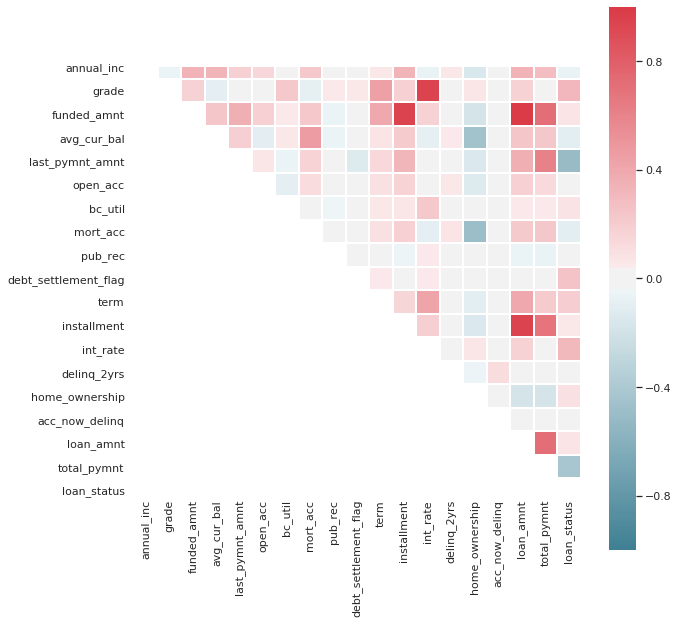

In [31]:
dataViz = data_clean
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

### ROC Plot function

Creating a ROC function to be used for all the models.

In [0]:
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

### Confusion Matrix function

Creating a Confusion Matrix function to be used for all the models.

In [0]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_clean_full.iloc[:,:-1],
                                                    data_clean_full.iloc[:,-1], test_size=0.2,
                                                    random_state=42)
bs_train, bs_test = train_test_split(data_clean_full, test_size = 0.2,
                                     random_state=42) #just for bootstrapping

In [35]:
X_train.head()

,annual_inc,grade,funded_amnt,avg_cur_bal,last_pymnt_amnt,open_acc,bc_util,mort_acc,pub_rec,debt_settlement_flag,term,installment,int_rate,delinq_2yrs,home_ownership,acc_now_delinq,loan_amnt,total_pymnt
370638,0.625863,0.191616,0.919086,1.117442,-0.660810,0.623511,1.418398,2.196310,-0.357498,-0.158607,-0.564300,1.196052,-0.140157,0.777864,-0.997298,-0.065476,0.917657,-0.592436
834646,-0.230682,1.733707,1.376220,-0.556260,2.414324,0.257565,1.414773,-0.851916,1.301257,-0.158607,1.772108,1.193256,2.130593,-0.362051,0.568545,-0.065476,1.374578,1.927309
128350,-0.758884,0.191616,-0.705324,-0.668728,-0.058527,-1.206221,1.215400,-0.851916,-0.357498,-0.158607,-0.564300,-0.574440,0.431207,-0.362051,-0.997298,-0.065476,-0.705992,-0.500133
1169890,-0.329370,0.962661,0.022067,1.486131,0.698485,-0.474328,-0.477455,-0.343878,-0.357498,-0.158607,1.772108,-0.270988,0.905943,-0.362051,-0.997298,-0.065476,0.021058,0.433674
1074160,-0.087924,-0.579430,0.068068,-0.587673,0.793341,3.917029,0.102538,0.164160,-0.357498,-0.158607,-0.564300,0.221307,-0.333412,-0.362051,1.090493,-0.065476,0.067037,0.173751


In [36]:
data_clean.isnull().sum()

annual_inc              0
grade                   0
funded_amnt             0
avg_cur_bal             0
last_pymnt_amnt         0
open_acc                0
bc_util                 0
mort_acc                0
pub_rec                 0
debt_settlement_flag    0
term                    0
installment             0
int_rate                0
delinq_2yrs             0
home_ownership          0
acc_now_delinq          0
loan_amnt               0
total_pymnt             0
loan_status             0
dtype: int64

## Models

### Random Forest with randomized search

In [37]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,data_clean.shape[1]-1)
param_dist = dict(max_features=maxFeatures)
rand = RandomizedSearchCV(rf, param_dist, cv=10, scoring='accuracy', n_iter=len(maxFeatures), random_state=10)
X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values
rand.fit(X,y)
# mean_scores = [result.mean_validation_score for result in rand.grid_scores_]
#print('Best Accuracy = '+str(rand.best_score_))
print(rand.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=12, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [38]:
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",max_features=rand.best_estimator_.max_features,random_state=0,n_jobs=-1 )
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1] #for ROC curve
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)

0.9951174047452842


### Feature Evaluation

Text(0, 0.5, 'Normalized Gini Importance')

findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.


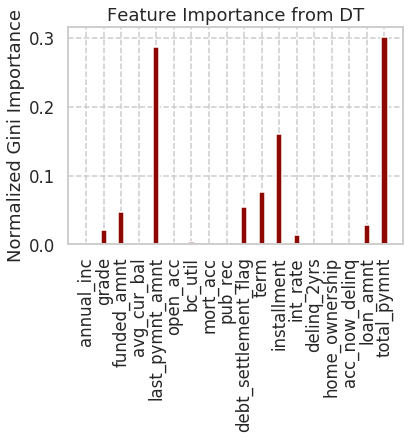

In [39]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(features)-2), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

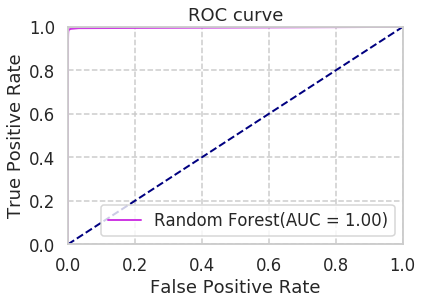

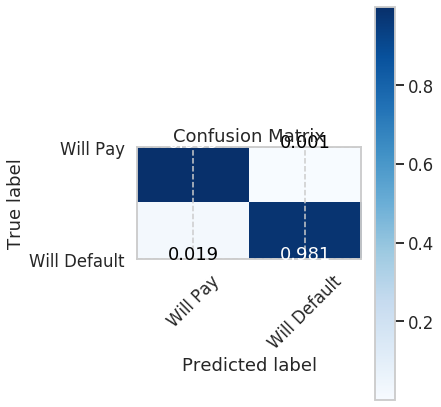

In [40]:
plotAUC(y_test,rfPredictproba, 'Random Forest')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(rfPredict, normalize=True)
plt.show()